In [1]:
import math
import csv
import time
from collections import Counter
from tqdm import tqdm
from typing import Optional, Tuple
import numpy as np

import torch
import torch.nn as nn
import torchtext
from torch import Tensor

import matplotlib.pyplot as plt
from collections import OrderedDict

from utils import *
from MultiheadAttention import *

加工済みの WMT16 (de->en) を読み込みます．
関数の詳細は utils.py を参照してください．
- WMT16 の加工は別プログラムで実行（気が向いたときに説明を記載します）

実行内容
- CSV ファイルからデータセットを読み込む
- トークナイズ
- ボキャブラリー統計
- データローダの作成
完了まで約５分くらかかります．

In [2]:
en_train_path = '../Datasets/custom_wmt16/train_en.csv'
de_train_path = '../Datasets/custom_wmt16/train_de.csv'

en_valid_path = '../Datasets/custom_wmt16/val_en.csv'
de_valid_path = '../Datasets/custom_wmt16/val_de.csv'

en_train_data = load_data(en_train_path)
de_train_data = load_data(de_train_path)

en_valid_data = load_data(en_valid_path)
de_valid_data = load_data(de_valid_path)

tokenizer_de = torchtext.data.utils.get_tokenizer('spacy', language='de_core_news_sm')
tokenizer_en = torchtext.data.utils.get_tokenizer('spacy', language='en_core_web_sm')

vocab_de = build_vocab(de_train_data)
vocab_en = build_vocab(en_train_data)
vocab_de.set_default_index(vocab_de['<unk>'])
vocab_en.set_default_index(vocab_en['<unk>'])

train_data = data_process(
    texts_src=de_train_data, texts_tgt=en_train_data,
    vocab_src=vocab_de, vocab_tgt=vocab_en
)

valid_data = data_process(
    texts_src=de_valid_data, texts_tgt=en_valid_data,
    vocab_src=vocab_de, vocab_tgt=vocab_en
)

batch_size = 16
PAD_IDX = vocab_de['<pad>']
START_IDX = vocab_de['<start>']
END_IDX = vocab_de['<end>']

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=batch_generator)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=batch_generator)

4165231it [00:30, 136347.49it/s]
4165113it [00:31, 130167.90it/s]
2169it [00:00, 287375.47it/s]
2169it [00:00, 278635.39it/s]
100%|█████████████████████████████████████████████████████████████████████| 4165231/4165231 [00:18<00:00, 225944.71it/s]
4165113it [03:27, 20037.50it/s]
2169it [00:00, 23284.87it/s]


エンコーダとデコーダの class です．
gate を付与しているため，L0 正則化を掛けるとゲートを減らせます．
- 詳細は下の学習時に説明

In [3]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model=512, dim_feedforward=2048, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        
        self.self_attn = MultiheadAttention(d_model, num_heads=8, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        
        self.norm1 = nn.LayerNorm(d_model, eps=1e-5)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-5)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        self.activation = nn.functional.relu
        
    def forward(self, src, src_mask, src_padding_mask):
        x = src
        
        x_, L0_loss = self._sa_block(x, src_mask, src_padding_mask)
        x = self.norm1(x + x_)
        x = self.norm2(x + self._ff_blck(x))
        
        return x, L0_loss
        
    def _sa_block(self, x, attn_mask, key_padding_mask):
        x, attn_map, L0_loss = self.self_attn(x, x, x, attn_mask=attn_mask, key_padding_mask=key_padding_mask)
        self.attention_map = attn_map.detach()
        
        return self.dropout1(x), L0_loss
    
    def _ff_blck(self, x):
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout2(x)

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers = 6, dim_feedforward=2048):
        super(TransformerEncoder, self).__init__()
        
        self.layers = nn.ModuleList([TransformerEncoderLayer() for i in range(num_layers)])
        self.self_attns = []
        
    def forward(self, src, src_mask, src_padding_mask):
        self.self_attns = []
        output = src
        
        for i, layer in enumerate(self.layers):
            output, L0_loss = layer(output, src_mask, src_padding_mask)
            self.self_attns.append(layer.attention_map)
        
        return output, L0_loss

class Transformer_Encoder(nn.Module):
    def __init__(
        self, embedding_size, vocab_size_src, dropout=0.1
    ):
        super(Transformer_Encoder, self).__init__()
        self.token_embedding_src = TokenEmbedding(vocab_size_src, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        
        self.transformer_encoder = TransformerEncoder()
        
    def forward(self, src, mask_src, padding_mask_src):
        embedding_src = self.positional_encoding(self.token_embedding_src(src))
        memory, L0_loss = self.transformer_encoder(embedding_src, mask_src, padding_mask_src)
        
        return memory, L0_loss

In [4]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model=512, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        
        self.self_attn = MultiheadAttention(d_model, num_heads=8, dropout=dropout)
        self.multihead_attn = MultiheadAttention(d_model, num_heads=8, dropout=dropout)
        
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        
        self.norm1 = nn.LayerNorm(d_model, eps=1e-5)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-5)
        self.norm3 = nn.LayerNorm(d_model, eps=1e-5)
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        
        self.activation = nn.functional.relu
        
    def forward(self, tgt, memory, tgt_mask, memory_mask, tgt_key_padding_mask, memory_key_padding_mask):
        x = tgt
        
        x_, L0_loss = self._sa_block(x, tgt_mask, tgt_key_padding_mask)
        x = self.norm1(x + x_)
        
        x_, L0_loss2 = self._mha_block(x, memory, memory_mask, memory_key_padding_mask)
        x = self.norm2(x + x_)
        x = self.norm3(x + self._ff_block(x))
        
        return x, L0_loss+L0_loss2
    
    def _sa_block(self, x, attn_mask, key_padding_mask):
        x, attn_map, L0_loss = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                          )
        
        self.attention_map = attn_map.detach()
        
        return self.dropout1(x), L0_loss
    
    def _mha_block(self, x, mem, attn_mask, key_padding_mask):
        x, attn_map, L0_loss = self.multihead_attn(x, mem, mem, 
                                attn_mask=attn_mask, 
                                key_padding_mask=key_padding_mask)
        self.attention_map2 = attn_map.detach()
        return self.dropout2(x), L0_loss
    
    def _ff_block(self, x):
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout3(x)
    
class TransformerDecoder(nn.Module):
    def __init__(self, num_layers=6, dim_feedforward=2048):
        super(TransformerDecoder, self).__init__()
        
        self.layers = nn.ModuleList([TransformerDecoderLayer() for i in range(num_layers)])
        self.self_attns = []
        self.self_attns2 = []
    
    def forward(self, tgt, memory, tgt_mask, memory_mask, tgt_key_padding_mask, memory_key_padding_mask):
        self.self_attns = []
        self.self_attns2 = []
        
        output = tgt
        
        for i, mod in enumerate(self.layers):
            output, L0_loss = mod(output, memory, tgt_mask,
                         memory_mask,
                         tgt_key_padding_mask,
                         memory_key_padding_mask)
            self.self_attns.append(mod.attention_map)
            self.self_attns2.append(mod.attention_map2)
            
        return output, L0_loss
    
class Transformer_Decoder(nn.Module):
    def __init__(
        self, embedding_size, vocab_size_tgt, dropout=0.1
    ):
        super(Transformer_Decoder, self).__init__()
        
        self.token_embedding_tgt = TokenEmbedding(vocab_size_tgt, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        
        self.transformer_decoder = TransformerDecoder()
    
    def forward(self, tgt, memory, mask_tgt, padding_mask_tgt, memory_key_padding_mask):
        embedding_tgt = self.positional_encoding(self.token_embedding_tgt(tgt))
        outs, L0_loss = self.transformer_decoder(embedding_tgt, memory, mask_tgt, None, padding_mask_tgt, memory_key_padding_mask)
        
        return outs, L0_loss

In [5]:
class Transformer_Linear(nn.Module):
    def __init__(self, embedding_size, vocab_size_tgt):
        super(Transformer_Linear, self).__init__()
        self.output = nn.Linear(embedding_size, vocab_size_tgt)
        
    def forward(self, outs):
        return self.output(outs)

In [6]:
embedding_size = 512

vocab_size_src = len(vocab_de)
vocab_size_tgt = len(vocab_en)

print('src vocab size: ', vocab_size_src)
print('tgt vocab size: ', vocab_size_tgt)

src vocab size:  1817025
tgt vocab size:  769754


In [7]:
def now_lambda(i, max_iter=1000, max_lambda=0.5):
    i_ = i if i <= max_iter else max_iter
    return max_lambda * math.sin(math.pi*i_/(max_iter*2))

教師モデルを学習します．
- 10000 iterations
- 10 iterations 毎に評価（誤差が小さかったら保存）

In [7]:
max_iter = 10000
interval = 10

In [8]:
T_enc = Transformer_Encoder(embedding_size, vocab_size_src).cuda(0)
T_dec = Transformer_Decoder(embedding_size, vocab_size_tgt).cuda(1)
T_fc = Transformer_Linear(embedding_size, vocab_size_tgt).cuda(2)

In [9]:
torch.save(T_enc.state_dict(), '../Models/T_enc_init.pth')
torch.save(T_dec.state_dict(), '../Models/T_dec_init.pth')
torch.save(T_fc.state_dict(), '../Models/T_fc_init.pth')

$\lambda$ を増やすと head の数が減ります．
教師モデルは head 数を変えたくないので 0.0 で初期化

In [10]:
lambda_ = 0.0
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam([{'params': T_enc.parameters()},{'params': T_dec.parameters()},{'params': T_fc.parameters()}])

In [11]:
val_loss_list = []
best_loss = float('inf')

loss_list = []

with tqdm(train_loader) as pbar:
    for i, (src, tgt) in enumerate(pbar):
        if i == max_iter:
            break
    
        T_enc.train()
        T_dec.train()
        T_fc.train()
    
        input_tgt = tgt[:-1, :]
        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)
    
        src = src.cuda(0)
        mask_src = mask_src.cuda(0)
        padding_mask_src = padding_mask_src.cuda(0)
        memory, L0_loss_enc = T_enc(src, mask_src, padding_mask_src)
    
        memory = memory.cuda(1)
        mask_tgt = mask_tgt.cuda(1)
        padding_mask_tgt = padding_mask_tgt.cuda(1)
        padding_mask_src = padding_mask_src.cuda(1)
        input_tgt = tgt[:-1, :].cuda(1)
        outs, L0_loss_dec = T_dec(input_tgt, memory, mask_tgt, padding_mask_tgt, padding_mask_src)
    
        outs = outs.cuda(2)
        logits = T_fc(outs)
    
        optimizer.zero_grad()
        output_tgt = tgt[1:, :].cuda(2)
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1)) + lambda_ * (L0_loss_enc.cuda(2) + L0_loss_dec.cuda(2))
        loss.backward()
    
        optimizer.step()
        loss_list.append(loss.item())
    
        if i % interval == 0:
            T_enc.eval()
            T_dec.eval()
            T_fc.eval()
        
            v_loss = 0
        
            for src_, tgt_ in valid_loader:
                input_tgt_ = tgt_[:-1, :]
                mask_src_, mask_tgt_, padding_mask_src_, padding_mask_tgt_ = create_mask(src_, input_tgt_, PAD_IDX)
            
                src_ = src_.cuda(0)
                mask_src_ = mask_src_.cuda(0)
                padding_mask_src_ = padding_mask_src_.cuda(0)
                memory_, L0_loss_enc_ = T_enc(src_, mask_src_, padding_mask_src_)
            
                memory_ = memory_.cuda(1)
                mask_tgt_ = mask_tgt_.cuda(1)
                padding_mask_tgt_ = padding_mask_tgt_.cuda(1)
                padding_mask_src_ = padding_mask_src_.cuda(1)
                input_tgt_ = tgt_[:-1, :].cuda(1)
                outs_, L0_loss_dec_ = T_dec(input_tgt_, memory_, mask_tgt_, padding_mask_tgt_, padding_mask_src_)
            
                outs_ = outs_.cuda(2)
                logits_ = T_fc(outs_)
            
                output_tgt_ = tgt_[1:, :].cuda(2)
                loss_ = criterion(logits_.reshape(-1, logits_.shape[-1]), output_tgt_.reshape(-1)) + lambda_ * (L0_loss_enc_.cuda(2) + L0_loss_enc_.cuda(2))
                v_loss += loss_.item()
                
            v_loss = v_loss / len(valid_loader)
            val_loss_list.append(v_loss)
        
            if best_loss > v_loss:
                best_loss = v_loss
            
                torch.save(T_enc.state_dict(), '../Models/T_enc.pth')
                torch.save(T_dec.state_dict(), '../Models/T_dec.pth')
                torch.save(T_fc.state_dict(), '../Models/T_fc.pth')
                
        pbar.set_postfix({"best_valid_loss": best_loss})

  4%|█▊                                              | 10000/260320 [4:26:01<110:59:07,  1.60s/it, best_valid_loss=7.53]


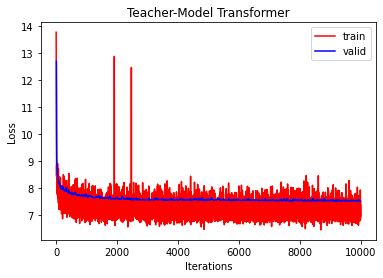

In [12]:
train_x = np.arange(1, len(loss_list)+1)
valid_x = np.arange(1, len(val_loss_list)+1) * 10

train_loss_list = np.array(loss_list)
val_loss_list = np.array(val_loss_list)

plt.plot(train_x, train_loss_list, label='train', color='red')
plt.plot(valid_x, val_loss_list, label='valid', color='blue')

plt.title('Teacher-Model Transformer')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.savefig('../Plots/T_model_loss')
plt.show()

In [13]:
np.savetxt('../Models/BaseLine_loss_train.txt', train_loss_list)
np.savetxt('../Models/BaseLine_loss_valid_txt', val_loss_list)

教師モデルから生徒モデルを学習します．
損失関数は KLDivLoss を使います．
- 教師モデルの学習が終了している場合はここから開始

In [7]:
T_enc = Transformer_Encoder(embedding_size, vocab_size_src).cuda(1)
T_dec = Transformer_Decoder(embedding_size, vocab_size_tgt).cuda(1)
T_fc = Transformer_Linear(embedding_size, vocab_size_tgt).cuda(1)

T_enc.load_state_dict(torch.load('../Models/T_enc.pth'))
T_dec.load_state_dict(torch.load('../Models/T_dec.pth'))
T_fc.load_state_dict(torch.load('../Models/T_fc.pth'))

<All keys matched successfully>

In [8]:
S_enc = Transformer_Encoder(embedding_size, vocab_size_src).cuda(0)
S_dec = Transformer_Decoder(embedding_size, vocab_size_tgt).cuda(1)
S_fc = Transformer_Linear(embedding_size, vocab_size_tgt).cuda(2)

S_enc.load_state_dict(torch.load('../Models/T_enc_init.pth'))
S_dec.load_state_dict(torch.load('../Models/T_dec_init.pth'))
S_fc.load_state_dict(torch.load('../Models/T_fc_init.pth'))

<All keys matched successfully>

最初の 1000 iter で徐々に $\lambda$ を 0.0 ~ 0.5 まで増加させます．

In [10]:
criterion = nn.KLDivLoss(reduction='batchmean')
criterion2 = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
max_iter = 10000
interval = 10
optimizer = torch.optim.Adam([{'params': S_enc.parameters()},{'params': S_dec.parameters()},{'params': S_fc.parameters()}])

In [11]:
val_loss_list = []
best_loss = float('inf')
loss_list = []

enc_gate = []
dec_gate = []
dec_gate2 = []

with tqdm(train_loader) as pbar:
    for i, (src, tgt) in enumerate(pbar):
        if i == max_iter:
            break
        
        lambda_ = now_lambda(i)
        T_enc.eval()
        T_dec.eval()
        T_fc.eval()
        
        S_enc.train()
        S_dec.train()
        S_fc.train()
    
        input_tgt = tgt[:-1, :]
        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)
        
        src = src.cuda(1)
        mask_src = mask_src.cuda(1)
        padding_mask_src = padding_mask_src.cuda(1)
        memory, _ = T_enc(src, mask_src, padding_mask_src)
        mask_tgt = mask_tgt.cuda(1)
        padding_mask_tgt = padding_mask_tgt.cuda(1)
        padding_mask_src = padding_mask_src.cuda(1)
        input_tgt = tgt[:-1, :].cuda(1)
        outs, _ = T_dec(input_tgt, memory, mask_tgt, padding_mask_tgt, padding_mask_src)
        T_logits = T_fc(outs)
        T_logits = T_logits.cuda(2)
        
        src = src.cuda(0)
        mask_src = mask_src.cuda(0)
        padding_mask_src = padding_mask_src.cuda(0)
        memory, L0_loss_enc = S_enc(src, mask_src, padding_mask_src)
    
        memory = memory.cuda(1)
        mask_tgt = mask_tgt.cuda(1)
        padding_mask_tgt = padding_mask_tgt.cuda(1)
        padding_mask_src = padding_mask_src.cuda(1)
        input_tgt = tgt[:-1, :].cuda(1)
        outs, L0_loss_dec = S_dec(input_tgt, memory, mask_tgt, padding_mask_tgt, padding_mask_src)
    
        outs = outs.cuda(2)
        S_logits = S_fc(outs)
        
        for l in S_enc.transformer_encoder.layers:
            enc_gate.append(l.self_attn.sparsity[1].detach().cpu())
        for l in S_dec.transformer_decoder.layers:
            dec_gate.append(l.self_attn.sparsity[1].detach().cpu())
            dec_gate2.append(l.multihead_attn.sparsity[1].detach().cpu())
    
        optimizer.zero_grad()
        
        loss = criterion(F.log_softmax(T_logits.reshape(-1, T_logits.shape[-1]), dim=1), F.softmax(S_logits.reshape(-1, S_logits.shape[-1]), dim=1)) + lambda_ * (L0_loss_enc.cuda(2) + L0_loss_enc.cuda(2))
        loss.backward()
    
        optimizer.step()
        loss_list.append(loss.item())
    
        if i % interval == 0:
            S_enc.eval()
            S_dec.eval()
            S_fc.eval()
        
            v_loss = 0
        
            for src_, tgt_ in valid_loader:
                input_tgt_ = tgt_[:-1, :]
                mask_src_, mask_tgt_, padding_mask_src_, padding_mask_tgt_ = create_mask(src_, input_tgt_, PAD_IDX)
            
                src_ = src_.cuda(0)
                mask_src_ = mask_src_.cuda(0)
                padding_mask_src_ = padding_mask_src_.cuda(0)
                memory_, L0_loss_enc_ = S_enc(src_, mask_src_, padding_mask_src_)
            
                memory_ = memory_.cuda(1)
                mask_tgt_ = mask_tgt_.cuda(1)
                padding_mask_tgt_ = padding_mask_tgt_.cuda(1)
                padding_mask_src_ = padding_mask_src_.cuda(1)
                input_tgt_ = tgt_[:-1, :].cuda(1)
                outs_, L0_loss_dec_ = S_dec(input_tgt_, memory_, mask_tgt_, padding_mask_tgt_, padding_mask_src_)
            
                outs_ = outs_.cuda(2)
                logits_ = S_fc(outs_)
            
                output_tgt_ = tgt_[1:, :].cuda(2)
                loss_ = criterion2(logits_.reshape(-1, logits_.shape[-1]), output_tgt_.reshape(-1)) + lambda_ * (L0_loss_enc_.cuda(2) + L0_loss_dec_.cuda(2))
                v_loss += loss_.item()
                
            v_loss = v_loss / len(valid_loader)
            val_loss_list.append(v_loss)
        
            if best_loss > v_loss:
                best_loss = v_loss
            
                torch.save(S_enc.state_dict(), '../Models/S_enc.pth')
                torch.save(S_dec.state_dict(), '../Models/S_dec.pth')
                torch.save(S_fc.state_dict(), '../Models/S_fc.pth')
                
        pbar.set_postfix({"best_loss": best_loss, 'now loss':v_loss})

  4%|█▍                                     | 10000/260320 [4:50:35<121:14:02,  1.74s/it, best_loss=8.09, now loss=14.6]


In [12]:
def calc_sparsity(gate, num_heads=8, num_layers=6):
    sum_heads = num_heads * num_layers
    len_seq = len(gate) // num_layers
    
    data = []
    for seq in range(len_seq):
        sum_ = sum([sum(sum(gate[seq*num_layers: seq*num_layers+num_layers]))])
        data.append(sum_)
    data = np.array(data)
    data /= sum_heads
    
    return data

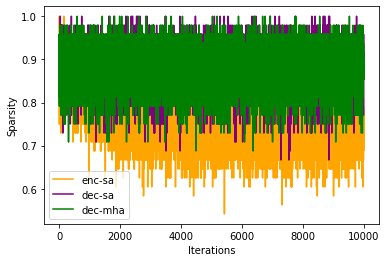

In [13]:
seq_len = max_iter

x = np.arange(1, seq_len + 1)
enc_y = calc_sparsity(enc_gate)
dec_y = calc_sparsity(dec_gate)
dec_y2 = calc_sparsity(dec_gate2)

plt.plot(x, enc_y, label='enc-sa', color='orange')
plt.plot(x, dec_y, label='dec-sa', color='purple')
plt.plot(x, dec_y2, label='dec-mha', color='green')

plt.xlabel('Iterations')
plt.ylabel('Sparsity')

plt.legend()

plt.show()

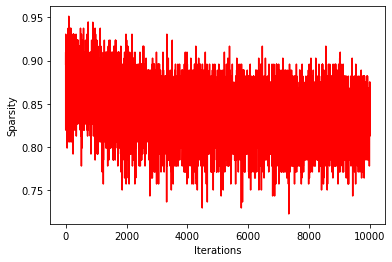

In [14]:
seq_len = max_iter

x = np.arange(1, seq_len + 1)
y = calc_sparsity(enc_gate) + calc_sparsity(dec_gate) + calc_sparsity(dec_gate2)
y /= 3.0

plt.plot(x, y, color='red')

plt.xlabel('Iterations')
plt.ylabel('Sparsity')

plt.show()

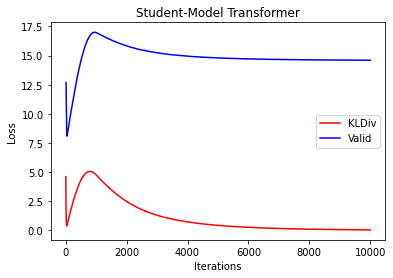

In [15]:
train_x = np.arange(1, len(loss_list)+1)
valid_x = np.arange(1, len(val_loss_list)+1) * 10

train_loss_list = np.array(loss_list)
val_loss_list = np.array(val_loss_list)

plt.plot(train_x, train_loss_list, label='KLDiv', color='red')
plt.plot(valid_x, val_loss_list, label='Valid', color='blue')

plt.title('Student-Model Transformer')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.savefig('../Plots/S_model_loss')
plt.show()

L0 loss を適用せず（$\lambda=0.0$）蒸留

In [9]:
criterion = nn.KLDivLoss(reduction='batchmean')
criterion2 = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
max_iter = 10000
interval = 10
optimizer = torch.optim.Adam([{'params': S_enc.parameters()},{'params': S_dec.parameters()},{'params': S_fc.parameters()}])

In [10]:
val_loss_list = []
best_loss = float('inf')
loss_list = []

enc_gate = []
dec_gate = []
dec_gate2 = []

with tqdm(train_loader) as pbar:
    for i, (src, tgt) in enumerate(pbar):
        if i == max_iter:
            break
        
        lambda_ = 0.0
        T_enc.eval()
        T_dec.eval()
        T_fc.eval()
        
        S_enc.train()
        S_dec.train()
        S_fc.train()
    
        input_tgt = tgt[:-1, :]
        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)
        
        src = src.cuda(1)
        mask_src = mask_src.cuda(1)
        padding_mask_src = padding_mask_src.cuda(1)
        memory, _ = T_enc(src, mask_src, padding_mask_src)
        mask_tgt = mask_tgt.cuda(1)
        padding_mask_tgt = padding_mask_tgt.cuda(1)
        padding_mask_src = padding_mask_src.cuda(1)
        input_tgt = tgt[:-1, :].cuda(1)
        outs, _ = T_dec(input_tgt, memory, mask_tgt, padding_mask_tgt, padding_mask_src)
        T_logits = T_fc(outs)
        T_logits = T_logits.cuda(2)
        
        src = src.cuda(0)
        mask_src = mask_src.cuda(0)
        padding_mask_src = padding_mask_src.cuda(0)
        memory, L0_loss_enc = S_enc(src, mask_src, padding_mask_src)
    
        memory = memory.cuda(1)
        mask_tgt = mask_tgt.cuda(1)
        padding_mask_tgt = padding_mask_tgt.cuda(1)
        padding_mask_src = padding_mask_src.cuda(1)
        input_tgt = tgt[:-1, :].cuda(1)
        outs, L0_loss_dec = S_dec(input_tgt, memory, mask_tgt, padding_mask_tgt, padding_mask_src)
    
        outs = outs.cuda(2)
        S_logits = S_fc(outs)
        
        for l in S_enc.transformer_encoder.layers:
            enc_gate.append(l.self_attn.sparsity[1].detach().cpu())
        for l in S_dec.transformer_decoder.layers:
            dec_gate.append(l.self_attn.sparsity[1].detach().cpu())
            dec_gate2.append(l.multihead_attn.sparsity[1].detach().cpu())
    
        optimizer.zero_grad()
        
        loss = criterion(F.log_softmax(T_logits.reshape(-1, T_logits.shape[-1]), dim=1), F.softmax(S_logits.reshape(-1, S_logits.shape[-1]), dim=1)) + lambda_ * (L0_loss_enc.cuda(2) + L0_loss_enc.cuda(2))
        loss.backward()
    
        optimizer.step()
        loss_list.append(loss.item())
    
        if i % interval == 0:
            S_enc.eval()
            S_dec.eval()
            S_fc.eval()
        
            v_loss = 0
        
            for src_, tgt_ in valid_loader:
                input_tgt_ = tgt_[:-1, :]
                mask_src_, mask_tgt_, padding_mask_src_, padding_mask_tgt_ = create_mask(src_, input_tgt_, PAD_IDX)
            
                src_ = src_.cuda(0)
                mask_src_ = mask_src_.cuda(0)
                padding_mask_src_ = padding_mask_src_.cuda(0)
                memory_, L0_loss_enc_ = S_enc(src_, mask_src_, padding_mask_src_)
            
                memory_ = memory_.cuda(1)
                mask_tgt_ = mask_tgt_.cuda(1)
                padding_mask_tgt_ = padding_mask_tgt_.cuda(1)
                padding_mask_src_ = padding_mask_src_.cuda(1)
                input_tgt_ = tgt_[:-1, :].cuda(1)
                outs_, L0_loss_dec_ = S_dec(input_tgt_, memory_, mask_tgt_, padding_mask_tgt_, padding_mask_src_)
            
                outs_ = outs_.cuda(2)
                logits_ = S_fc(outs_)
            
                output_tgt_ = tgt_[1:, :].cuda(2)
                loss_ = criterion2(logits_.reshape(-1, logits_.shape[-1]), output_tgt_.reshape(-1)) + lambda_ * (L0_loss_enc_.cuda(2) + L0_loss_dec_.cuda(2))
                v_loss += loss_.item()
                
            v_loss = v_loss / len(valid_loader)
            val_loss_list.append(v_loss)
        
            if best_loss > v_loss:
                best_loss = v_loss
            
                torch.save(S_enc.state_dict(), '../Models/S_enc_KD_LAM0.pth')
                torch.save(S_dec.state_dict(), '../Models/S_dec_KD_LAM0.pth')
                torch.save(S_fc.state_dict(), '../Models/S_fc_KD_LAM0.pth')
                
        pbar.set_postfix({"best_loss": best_loss, 'now loss':v_loss})

  4%|█▍                                     | 10000/260320 [5:03:09<126:28:36,  1.82s/it, best_loss=7.53, now loss=7.54]


In [11]:
def calc_sparsity(gate, num_heads=8, num_layers=6):
    sum_heads = num_heads * num_layers
    len_seq = len(gate) // num_layers
    
    data = []
    for seq in range(len_seq):
        sum_ = sum([sum(sum(gate[seq*num_layers: seq*num_layers+num_layers]))])
        data.append(sum_)
    data = np.array(data)
    data /= sum_heads
    
    return data

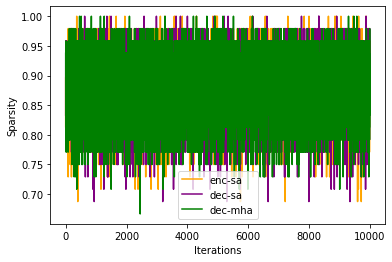

In [12]:
seq_len = max_iter

x = np.arange(1, seq_len + 1)
enc_y = calc_sparsity(enc_gate)
dec_y = calc_sparsity(dec_gate)
dec_y2 = calc_sparsity(dec_gate2)

plt.plot(x, enc_y, label='enc-sa', color='orange')
plt.plot(x, dec_y, label='dec-sa', color='purple')
plt.plot(x, dec_y2, label='dec-mha', color='green')

plt.xlabel('Iterations')
plt.ylabel('Sparsity')

plt.legend()

plt.show()

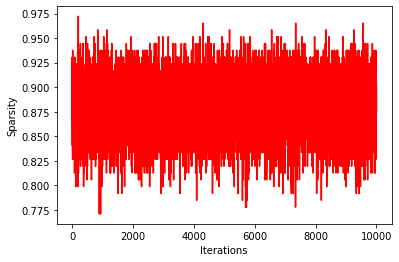

In [13]:
seq_len = max_iter

x = np.arange(1, seq_len + 1)
y = calc_sparsity(enc_gate) + calc_sparsity(dec_gate) + calc_sparsity(dec_gate2)
y /= 3.0

plt.plot(x, y, color='red')

plt.xlabel('Iterations')
plt.ylabel('Sparsity')

plt.show()

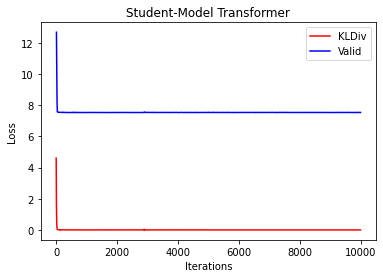

In [14]:
train_x = np.arange(1, len(loss_list)+1)
valid_x = np.arange(1, len(val_loss_list)+1) * 10

train_loss_list = np.array(loss_list)
val_loss_list = np.array(val_loss_list)

plt.plot(train_x, train_loss_list, label='KLDiv', color='red')
plt.plot(valid_x, val_loss_list, label='Valid', color='blue')

plt.title('Student-Model Transformer')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.savefig('../Plots/S_model_loss_KD_LAM0.png')
plt.show()

L0 Loss を，蒸留過程ではなくWMT16 の学習過程で適用
- 上の実験で過学習が起きたため，蒸留を抜きで実験

In [7]:
max_iter = 10000
interval = 10

In [8]:
S_enc = Transformer_Encoder(embedding_size, vocab_size_src).cuda(0)
S_dec = Transformer_Decoder(embedding_size, vocab_size_tgt).cuda(1)
S_fc = Transformer_Linear(embedding_size, vocab_size_tgt).cuda(2)

S_enc.load_state_dict(torch.load('../Models/T_enc_init.pth'))
S_dec.load_state_dict(torch.load('../Models/T_dec_init.pth'))
S_fc.load_state_dict(torch.load('../Models/T_fc_init.pth'))

<All keys matched successfully>

In [9]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam([{'params': S_enc.parameters()},{'params': S_dec.parameters()},{'params': S_fc.parameters()}])

In [12]:
val_loss_list = []
best_loss = float('inf')
loss_list = []

enc_gate = []
dec_gate = []
dec_gate2 = []

with tqdm(train_loader) as pbar:
    for i, (src, tgt) in enumerate(pbar):
        if i == max_iter:
            break
        
        lambda_ = now_lambda(i)
        
        S_enc.train()
        S_dec.train()
        S_fc.train()
    
        input_tgt = tgt[:-1, :]
        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)
        
        src = src.cuda(0)
        mask_src = mask_src.cuda(0)
        padding_mask_src = padding_mask_src.cuda(0)
        memory, L0_loss_enc = S_enc(src, mask_src, padding_mask_src)
    
        memory = memory.cuda(1)
        mask_tgt = mask_tgt.cuda(1)
        padding_mask_tgt = padding_mask_tgt.cuda(1)
        padding_mask_src = padding_mask_src.cuda(1)
        input_tgt = tgt[:-1, :].cuda(1)
        outs, L0_loss_dec = S_dec(input_tgt, memory, mask_tgt, padding_mask_tgt, padding_mask_src)
    
        outs = outs.cuda(2)
        S_logits = S_fc(outs)
        
        for l in S_enc.transformer_encoder.layers:
            enc_gate.append(l.self_attn.sparsity[1].detach().cpu())
        for l in S_dec.transformer_decoder.layers:
            dec_gate.append(l.self_attn.sparsity[1].detach().cpu())
            dec_gate2.append(l.multihead_attn.sparsity[1].detach().cpu())
    
        optimizer.zero_grad()
        output_tgt_ = tgt[1:, :].cuda(2)
        loss = criterion(S_logits.reshape(-1, S_logits.shape[-1]), output_tgt_.reshape(-1)) + lambda_ * (L0_loss_enc.cuda(2) + L0_loss_dec.cuda(2))
        loss.backward()
    
        optimizer.step()
        loss_list.append(loss.item())
    
        if i % interval == 0:
            S_enc.eval()
            S_dec.eval()
            S_fc.eval()
        
            v_loss = 0
        
            for src_, tgt_ in valid_loader:
                input_tgt_ = tgt_[:-1, :]
                mask_src_, mask_tgt_, padding_mask_src_, padding_mask_tgt_ = create_mask(src_, input_tgt_, PAD_IDX)
            
                src_ = src_.cuda(0)
                mask_src_ = mask_src_.cuda(0)
                padding_mask_src_ = padding_mask_src_.cuda(0)
                memory_, L0_loss_enc_ = S_enc(src_, mask_src_, padding_mask_src_)
            
                memory_ = memory_.cuda(1)
                mask_tgt_ = mask_tgt_.cuda(1)
                padding_mask_tgt_ = padding_mask_tgt_.cuda(1)
                padding_mask_src_ = padding_mask_src_.cuda(1)
                input_tgt_ = tgt_[:-1, :].cuda(1)
                outs_, L0_loss_dec_ = S_dec(input_tgt_, memory_, mask_tgt_, padding_mask_tgt_, padding_mask_src_)
            
                outs_ = outs_.cuda(2)
                logits_ = S_fc(outs_)
            
                output_tgt_ = tgt_[1:, :].cuda(2)
                loss_ = criterion(logits_.reshape(-1, logits_.shape[-1]), output_tgt_.reshape(-1)) + lambda_ * (L0_loss_enc_.cuda(2) + L0_loss_dec_.cuda(2))
                v_loss += loss_.item()
                
            v_loss = v_loss / len(valid_loader)
            val_loss_list.append(v_loss)
        
            if best_loss > v_loss:
                best_loss = v_loss
            
                torch.save(S_enc.state_dict(), '../Models/S_enc_WMT.pth')
                torch.save(S_dec.state_dict(), '../Models/S_dec_WMT.pth')
                torch.save(S_fc.state_dict(), '../Models/S_fc_WMT.pth')
                
        pbar.set_postfix({"best_loss": best_loss, 'now_loss':v_loss})

  4%|█▍                                     | 10000/260320 [7:50:11<196:09:43,  2.82s/it, best_loss=7.61, now_loss=7.62]


In [13]:
def calc_sparsity(gate, num_heads=8, num_layers=6):
    sum_heads = num_heads * num_layers
    len_seq = len(gate) // num_layers
    
    data = []
    for seq in range(len_seq):
        sum_ = sum([sum(sum(gate[seq*num_layers: seq*num_layers+num_layers]))])
        data.append(sum_)
    data = np.array(data)
    data /= sum_heads
    
    return data

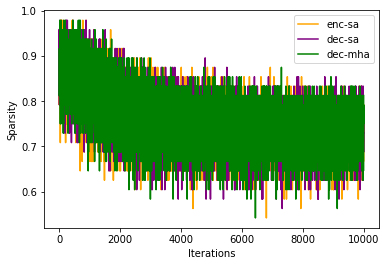

In [14]:
seq_len = max_iter

x = np.arange(1, seq_len + 1)
enc_y = calc_sparsity(enc_gate)
dec_y = calc_sparsity(dec_gate)
dec_y2 = calc_sparsity(dec_gate2)

plt.plot(x, enc_y, label='enc-sa', color='orange')
plt.plot(x, dec_y, label='dec-sa', color='purple')
plt.plot(x, dec_y2, label='dec-mha', color='green')

plt.xlabel('Iterations')
plt.ylabel('Sparsity')

plt.legend()

plt.show()

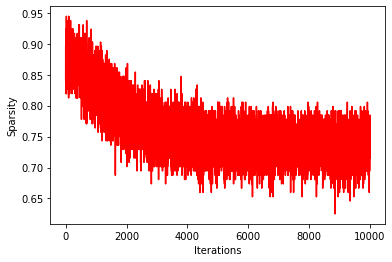

In [15]:
seq_len = max_iter

x = np.arange(1, seq_len + 1)
y = calc_sparsity(enc_gate) + calc_sparsity(dec_gate) + calc_sparsity(dec_gate2)
y /= 3.0

plt.plot(x, y, color='red')

plt.xlabel('Iterations')
plt.ylabel('Sparsity')

plt.show()

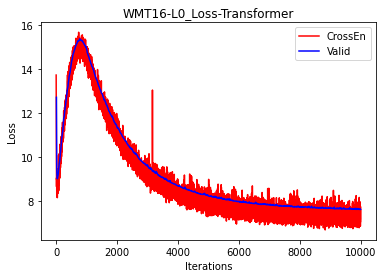

In [16]:
train_x = np.arange(1, len(loss_list)+1)
valid_x = np.arange(1, len(val_loss_list)+1) * 10

train_loss_list = np.array(loss_list)
val_loss_list = np.array(val_loss_list)

plt.plot(train_x, train_loss_list, label='CrossEn', color='red')
plt.plot(valid_x, val_loss_list, label='Valid', color='blue')

plt.title('WMT16-L0_Loss-Transformer')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.savefig('../Plots/S_model_L0loss_WMT')
plt.show()

$\lambda = 0.5$ で一定にして学習 

In [7]:
max_iter = 10000
interval = 10

In [8]:
S_enc = Transformer_Encoder(embedding_size, vocab_size_src).cuda(0)
S_dec = Transformer_Decoder(embedding_size, vocab_size_tgt).cuda(1)
S_fc = Transformer_Linear(embedding_size, vocab_size_tgt).cuda(2)

S_enc.load_state_dict(torch.load('../Models/T_enc_init.pth'))
S_dec.load_state_dict(torch.load('../Models/T_dec_init.pth'))
S_fc.load_state_dict(torch.load('../Models/T_fc_init.pth'))

<All keys matched successfully>

In [9]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam([{'params': S_enc.parameters()},{'params': S_dec.parameters()},{'params': S_fc.parameters()}])

In [10]:
val_loss_list = []
best_loss = float('inf')
loss_list = []

enc_gate = []
dec_gate = []
dec_gate2 = []

lambda_ = 0.5

with tqdm(train_loader) as pbar:
    for i, (src, tgt) in enumerate(pbar):
        if i == max_iter:
            break
        
        S_enc.train()
        S_dec.train()
        S_fc.train()
    
        input_tgt = tgt[:-1, :]
        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)
        
        src = src.cuda(0)
        mask_src = mask_src.cuda(0)
        padding_mask_src = padding_mask_src.cuda(0)
        memory, L0_loss_enc = S_enc(src, mask_src, padding_mask_src)
    
        memory = memory.cuda(1)
        mask_tgt = mask_tgt.cuda(1)
        padding_mask_tgt = padding_mask_tgt.cuda(1)
        padding_mask_src = padding_mask_src.cuda(1)
        input_tgt = tgt[:-1, :].cuda(1)
        outs, L0_loss_dec = S_dec(input_tgt, memory, mask_tgt, padding_mask_tgt, padding_mask_src)
    
        outs = outs.cuda(2)
        S_logits = S_fc(outs)
        
        for l in S_enc.transformer_encoder.layers:
            enc_gate.append(l.self_attn.sparsity[1].detach().cpu())
        for l in S_dec.transformer_decoder.layers:
            dec_gate.append(l.self_attn.sparsity[1].detach().cpu())
            dec_gate2.append(l.multihead_attn.sparsity[1].detach().cpu())
    
        optimizer.zero_grad()
        output_tgt_ = tgt[1:, :].cuda(2)
        loss = criterion(S_logits.reshape(-1, S_logits.shape[-1]), output_tgt_.reshape(-1)) + lambda_ * (L0_loss_enc.cuda(2) + L0_loss_dec.cuda(2))
        loss.backward()
    
        optimizer.step()
        loss_list.append(loss.item())
    
        if i % interval == 0:
            S_enc.eval()
            S_dec.eval()
            S_fc.eval()
        
            v_loss = 0
        
            for src_, tgt_ in valid_loader:
                input_tgt_ = tgt_[:-1, :]
                mask_src_, mask_tgt_, padding_mask_src_, padding_mask_tgt_ = create_mask(src_, input_tgt_, PAD_IDX)
            
                src_ = src_.cuda(0)
                mask_src_ = mask_src_.cuda(0)
                padding_mask_src_ = padding_mask_src_.cuda(0)
                memory_, L0_loss_enc_ = S_enc(src_, mask_src_, padding_mask_src_)
            
                memory_ = memory_.cuda(1)
                mask_tgt_ = mask_tgt_.cuda(1)
                padding_mask_tgt_ = padding_mask_tgt_.cuda(1)
                padding_mask_src_ = padding_mask_src_.cuda(1)
                input_tgt_ = tgt_[:-1, :].cuda(1)
                outs_, L0_loss_dec_ = S_dec(input_tgt_, memory_, mask_tgt_, padding_mask_tgt_, padding_mask_src_)
            
                outs_ = outs_.cuda(2)
                logits_ = S_fc(outs_)
            
                output_tgt_ = tgt_[1:, :].cuda(2)
                loss_ = criterion(logits_.reshape(-1, logits_.shape[-1]), output_tgt_.reshape(-1)) + lambda_ * (L0_loss_enc_.cuda(2) + L0_loss_dec_.cuda(2))
                v_loss += loss_.item()
                
            v_loss = v_loss / len(valid_loader)
            val_loss_list.append(v_loss)
        
            if best_loss > v_loss:
                best_loss = v_loss
            
                torch.save(S_enc.state_dict(), '../Models/S_enc_WMT_constLAM05.pth')
                torch.save(S_dec.state_dict(), '../Models/S_dec_WMT_constLAM05.pth')
                torch.save(S_fc.state_dict(), '../Models/S_fc_WMT_constLAM05.pth')
                
        pbar.set_postfix({"best_loss": best_loss, 'now_loss':v_loss})

  4%|█▍                                     | 10000/260320 [6:51:34<171:42:39,  2.47s/it, best_loss=8.81, now_loss=10.8]


In [11]:
def calc_sparsity(gate, num_heads=8, num_layers=6):
    sum_heads = num_heads * num_layers
    len_seq = len(gate) // num_layers
    
    data = []
    for seq in range(len_seq):
        sum_ = sum([sum(sum(gate[seq*num_layers: seq*num_layers+num_layers]))])
        data.append(sum_)
    data = np.array(data)
    data /= sum_heads
    
    return data

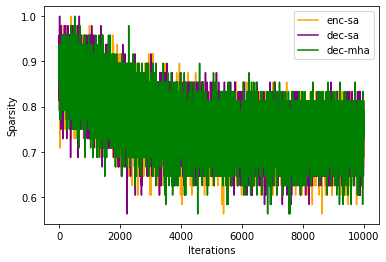

In [12]:
seq_len = max_iter

x = np.arange(1, seq_len + 1)
enc_y = calc_sparsity(enc_gate)
dec_y = calc_sparsity(dec_gate)
dec_y2 = calc_sparsity(dec_gate2)

plt.plot(x, enc_y, label='enc-sa', color='orange')
plt.plot(x, dec_y, label='dec-sa', color='purple')
plt.plot(x, dec_y2, label='dec-mha', color='green')

plt.xlabel('Iterations')
plt.ylabel('Sparsity')

plt.legend()

plt.show()

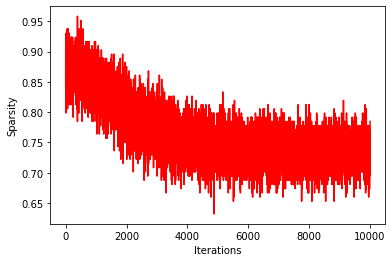

In [13]:
seq_len = max_iter

x = np.arange(1, seq_len + 1)
y = calc_sparsity(enc_gate) + calc_sparsity(dec_gate) + calc_sparsity(dec_gate2)
y /= 3.0

plt.plot(x, y, color='red')

plt.xlabel('Iterations')
plt.ylabel('Sparsity')

plt.show()

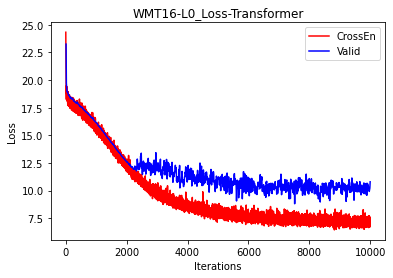

In [14]:
train_x = np.arange(1, len(loss_list)+1)
valid_x = np.arange(1, len(val_loss_list)+1) * 10

train_loss_list = np.array(loss_list)
val_loss_list = np.array(val_loss_list)

plt.plot(train_x, train_loss_list, label='CrossEn', color='red')
plt.plot(valid_x, val_loss_list, label='Valid', color='blue')

plt.title('WMT16-L0_Loss-Transformer')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.savefig('../Plots/S_model_L0loss_WMT')
plt.show()

$\lambda = 0.2$ で一定にして学習

In [8]:
max_iter = 10000
interval = 10

In [9]:
S_enc = Transformer_Encoder(embedding_size, vocab_size_src).cuda(0)
S_dec = Transformer_Decoder(embedding_size, vocab_size_tgt).cuda(1)
S_fc = Transformer_Linear(embedding_size, vocab_size_tgt).cuda(2)

S_enc.load_state_dict(torch.load('../Models/T_enc_init.pth'))
S_dec.load_state_dict(torch.load('../Models/T_dec_init.pth'))
S_fc.load_state_dict(torch.load('../Models/T_fc_init.pth'))

<All keys matched successfully>

In [10]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam([{'params': S_enc.parameters()},{'params': S_dec.parameters()},{'params': S_fc.parameters()}])

In [11]:
val_loss_list = []
best_loss = float('inf')
loss_list = []

enc_gate = []
dec_gate = []
dec_gate2 = []

lambda_ = 0.2

with tqdm(train_loader) as pbar:
    for i, (src, tgt) in enumerate(pbar):
        if i == max_iter:
            break
        
        S_enc.train()
        S_dec.train()
        S_fc.train()
    
        input_tgt = tgt[:-1, :]
        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)
        
        src = src.cuda(0)
        mask_src = mask_src.cuda(0)
        padding_mask_src = padding_mask_src.cuda(0)
        memory, L0_loss_enc = S_enc(src, mask_src, padding_mask_src)
    
        memory = memory.cuda(1)
        mask_tgt = mask_tgt.cuda(1)
        padding_mask_tgt = padding_mask_tgt.cuda(1)
        padding_mask_src = padding_mask_src.cuda(1)
        input_tgt = tgt[:-1, :].cuda(1)
        outs, L0_loss_dec = S_dec(input_tgt, memory, mask_tgt, padding_mask_tgt, padding_mask_src)
    
        outs = outs.cuda(2)
        S_logits = S_fc(outs)
        
        for l in S_enc.transformer_encoder.layers:
            enc_gate.append(l.self_attn.sparsity[1].detach().cpu())
        for l in S_dec.transformer_decoder.layers:
            dec_gate.append(l.self_attn.sparsity[1].detach().cpu())
            dec_gate2.append(l.multihead_attn.sparsity[1].detach().cpu())
    
        optimizer.zero_grad()
        output_tgt_ = tgt[1:, :].cuda(2)
        loss = criterion(S_logits.reshape(-1, S_logits.shape[-1]), output_tgt_.reshape(-1)) + lambda_ * (L0_loss_enc.cuda(2) + L0_loss_dec.cuda(2))
        loss.backward()
    
        optimizer.step()
        loss_list.append(loss.item())
    
        if i % interval == 0:
            S_enc.eval()
            S_dec.eval()
            S_fc.eval()
        
            v_loss = 0
        
            for src_, tgt_ in valid_loader:
                input_tgt_ = tgt_[:-1, :]
                mask_src_, mask_tgt_, padding_mask_src_, padding_mask_tgt_ = create_mask(src_, input_tgt_, PAD_IDX)
            
                src_ = src_.cuda(0)
                mask_src_ = mask_src_.cuda(0)
                padding_mask_src_ = padding_mask_src_.cuda(0)
                memory_, L0_loss_enc_ = S_enc(src_, mask_src_, padding_mask_src_)
            
                memory_ = memory_.cuda(1)
                mask_tgt_ = mask_tgt_.cuda(1)
                padding_mask_tgt_ = padding_mask_tgt_.cuda(1)
                padding_mask_src_ = padding_mask_src_.cuda(1)
                input_tgt_ = tgt_[:-1, :].cuda(1)
                outs_, L0_loss_dec_ = S_dec(input_tgt_, memory_, mask_tgt_, padding_mask_tgt_, padding_mask_src_)
            
                outs_ = outs_.cuda(2)
                logits_ = S_fc(outs_)
            
                output_tgt_ = tgt_[1:, :].cuda(2)
                loss_ = criterion(logits_.reshape(-1, logits_.shape[-1]), output_tgt_.reshape(-1)) + lambda_ * (L0_loss_enc_.cuda(2) + L0_loss_dec_.cuda(2))
                v_loss += loss_.item()
                
            v_loss = v_loss / len(valid_loader)
            val_loss_list.append(v_loss)
        
            if best_loss > v_loss:
                best_loss = v_loss
            
                torch.save(S_enc.state_dict(), '../Models/S_enc_WMT_constLAM02.pth')
                torch.save(S_dec.state_dict(), '../Models/S_dec_WMT_constLAM02.pth')
                torch.save(S_fc.state_dict(), '../Models/S_fc_WMT_constLAM02.pth')
                
        pbar.set_postfix({"best_loss": best_loss, 'now_loss':v_loss})

  4%|█▍                                    | 10000/260320 [10:40:36<267:15:43,  3.84s/it, best_loss=7.57, now_loss=7.57]


In [12]:
def calc_sparsity(gate, num_heads=8, num_layers=6):
    sum_heads = num_heads * num_layers
    len_seq = len(gate) // num_layers
    
    data = []
    for seq in range(len_seq):
        sum_ = sum([sum(sum(gate[seq*num_layers: seq*num_layers+num_layers]))])
        data.append(sum_)
    data = np.array(data)
    data /= sum_heads
    
    return data

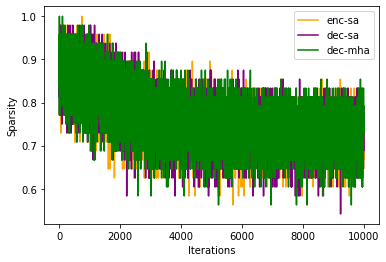

In [13]:
seq_len = max_iter

x = np.arange(1, seq_len + 1)
enc_y = calc_sparsity(enc_gate)
dec_y = calc_sparsity(dec_gate)
dec_y2 = calc_sparsity(dec_gate2)

plt.plot(x, enc_y, label='enc-sa', color='orange')
plt.plot(x, dec_y, label='dec-sa', color='purple')
plt.plot(x, dec_y2, label='dec-mha', color='green')

plt.xlabel('Iterations')
plt.ylabel('Sparsity')

plt.legend()

plt.show()

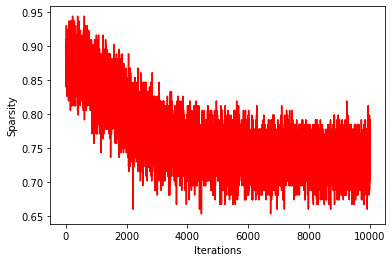

In [14]:
seq_len = max_iter

x = np.arange(1, seq_len + 1)
y = calc_sparsity(enc_gate) + calc_sparsity(dec_gate) + calc_sparsity(dec_gate2)
y /= 3.0

plt.plot(x, y, color='red')

plt.xlabel('Iterations')
plt.ylabel('Sparsity')

plt.show()

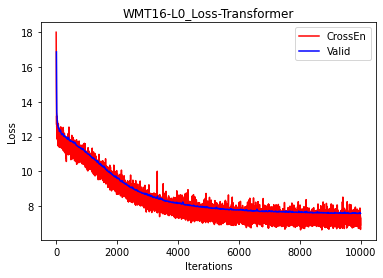

In [15]:
train_x = np.arange(1, len(loss_list)+1)
valid_x = np.arange(1, len(val_loss_list)+1) * 10

train_loss_list = np.array(loss_list)
val_loss_list = np.array(val_loss_list)

plt.plot(train_x, train_loss_list, label='CrossEn', color='red')
plt.plot(valid_x, val_loss_list, label='Valid', color='blue')

plt.title('WMT16-L0_Loss-Transformer')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.savefig('../Plots/S_model_L0loss_WMT_constLAM02.png')
plt.show()

$\lambda = 0.1 $ のとき

In [8]:
max_iter = 10000
interval = 10

In [9]:
S_enc = Transformer_Encoder(embedding_size, vocab_size_src).cuda(0)
S_dec = Transformer_Decoder(embedding_size, vocab_size_tgt).cuda(1)
S_fc = Transformer_Linear(embedding_size, vocab_size_tgt).cuda(2)

S_enc.load_state_dict(torch.load('../Models/T_enc_init.pth'))
S_dec.load_state_dict(torch.load('../Models/T_dec_init.pth'))
S_fc.load_state_dict(torch.load('../Models/T_fc_init.pth'))

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam([{'params': S_enc.parameters()},{'params': S_dec.parameters()},{'params': S_fc.parameters()}])

In [10]:
val_loss_list = []
best_loss = float('inf')
loss_list = []

enc_gate = []
dec_gate = []
dec_gate2 = []

lambda_ = 0.1

with tqdm(train_loader) as pbar:
    for i, (src, tgt) in enumerate(pbar):
        if i == max_iter:
            break
        
        S_enc.train()
        S_dec.train()
        S_fc.train()
    
        input_tgt = tgt[:-1, :]
        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)
        
        src = src.cuda(0)
        mask_src = mask_src.cuda(0)
        padding_mask_src = padding_mask_src.cuda(0)
        memory, L0_loss_enc = S_enc(src, mask_src, padding_mask_src)
    
        memory = memory.cuda(1)
        mask_tgt = mask_tgt.cuda(1)
        padding_mask_tgt = padding_mask_tgt.cuda(1)
        padding_mask_src = padding_mask_src.cuda(1)
        input_tgt = tgt[:-1, :].cuda(1)
        outs, L0_loss_dec = S_dec(input_tgt, memory, mask_tgt, padding_mask_tgt, padding_mask_src)
    
        outs = outs.cuda(2)
        S_logits = S_fc(outs)
        
        for l in S_enc.transformer_encoder.layers:
            enc_gate.append(l.self_attn.sparsity[1].detach().cpu())
        for l in S_dec.transformer_decoder.layers:
            dec_gate.append(l.self_attn.sparsity[1].detach().cpu())
            dec_gate2.append(l.multihead_attn.sparsity[1].detach().cpu())
    
        optimizer.zero_grad()
        output_tgt_ = tgt[1:, :].cuda(2)
        loss = criterion(S_logits.reshape(-1, S_logits.shape[-1]), output_tgt_.reshape(-1)) + lambda_ * (L0_loss_enc.cuda(2) + L0_loss_dec.cuda(2))
        loss.backward()
    
        optimizer.step()
        loss_list.append(loss.item())
    
        if i % interval == 0:
            S_enc.eval()
            S_dec.eval()
            S_fc.eval()
        
            v_loss = 0
        
            for src_, tgt_ in valid_loader:
                input_tgt_ = tgt_[:-1, :]
                mask_src_, mask_tgt_, padding_mask_src_, padding_mask_tgt_ = create_mask(src_, input_tgt_, PAD_IDX)
            
                src_ = src_.cuda(0)
                mask_src_ = mask_src_.cuda(0)
                padding_mask_src_ = padding_mask_src_.cuda(0)
                memory_, L0_loss_enc_ = S_enc(src_, mask_src_, padding_mask_src_)
            
                memory_ = memory_.cuda(1)
                mask_tgt_ = mask_tgt_.cuda(1)
                padding_mask_tgt_ = padding_mask_tgt_.cuda(1)
                padding_mask_src_ = padding_mask_src_.cuda(1)
                input_tgt_ = tgt_[:-1, :].cuda(1)
                outs_, L0_loss_dec_ = S_dec(input_tgt_, memory_, mask_tgt_, padding_mask_tgt_, padding_mask_src_)
            
                outs_ = outs_.cuda(2)
                logits_ = S_fc(outs_)
            
                output_tgt_ = tgt_[1:, :].cuda(2)
                loss_ = criterion(logits_.reshape(-1, logits_.shape[-1]), output_tgt_.reshape(-1)) + lambda_ * (L0_loss_enc_.cuda(2) + L0_loss_dec_.cuda(2))
                v_loss += loss_.item()
                
            v_loss = v_loss / len(valid_loader)
            val_loss_list.append(v_loss)
        
            if best_loss > v_loss:
                best_loss = v_loss
            
                torch.save(S_enc.state_dict(), '../Models/S_enc_WMT_constLAM01.pth')
                torch.save(S_dec.state_dict(), '../Models/S_dec_WMT_constLAM01.pth')
                torch.save(S_fc.state_dict(), '../Models/S_fc_WMT_constLAM01.pth')
                
        pbar.set_postfix({"best_loss": best_loss, 'now_loss':v_loss})

  4%|█▍                                     | 10000/260320 [8:02:06<201:08:17,  2.89s/it, best_loss=7.56, now_loss=7.56]


In [11]:
def calc_sparsity(gate, num_heads=8, num_layers=6):
    sum_heads = num_heads * num_layers
    len_seq = len(gate) // num_layers
    
    data = []
    for seq in range(len_seq):
        sum_ = sum([sum(sum(gate[seq*num_layers: seq*num_layers+num_layers]))])
        data.append(sum_)
    data = np.array(data)
    data /= sum_heads
    
    return data

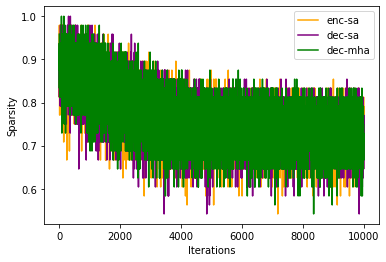

In [12]:
seq_len = max_iter

x = np.arange(1, seq_len + 1)
enc_y = calc_sparsity(enc_gate)
dec_y = calc_sparsity(dec_gate)
dec_y2 = calc_sparsity(dec_gate2)

plt.plot(x, enc_y, label='enc-sa', color='orange')
plt.plot(x, dec_y, label='dec-sa', color='purple')
plt.plot(x, dec_y2, label='dec-mha', color='green')

plt.xlabel('Iterations')
plt.ylabel('Sparsity')

plt.legend()

plt.show()

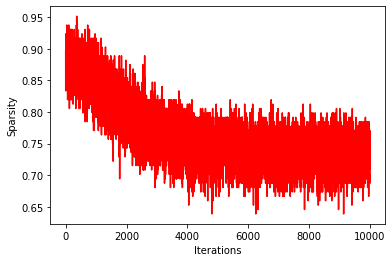

In [13]:
seq_len = max_iter

x = np.arange(1, seq_len + 1)
y = calc_sparsity(enc_gate) + calc_sparsity(dec_gate) + calc_sparsity(dec_gate2)
y /= 3.0

plt.plot(x, y, color='red')

plt.xlabel('Iterations')
plt.ylabel('Sparsity')

plt.show()

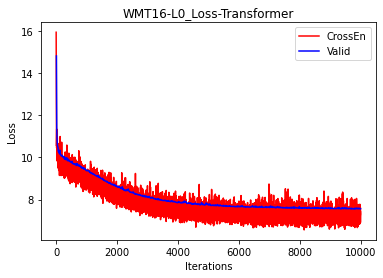

In [14]:
train_x = np.arange(1, len(loss_list)+1)
valid_x = np.arange(1, len(val_loss_list)+1) * 10

train_loss_list = np.array(loss_list)
val_loss_list = np.array(val_loss_list)

plt.plot(train_x, train_loss_list, label='CrossEn', color='red')
plt.plot(valid_x, val_loss_list, label='Valid', color='blue')

plt.title('WMT16-L0_Loss-Transformer')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.savefig('../Plots/S_model_L0loss_WMT_constLAM01.png')
plt.show()

$\lambda = 0.3$

In [ ]:
max_iter = 10000
interval = 10

In [ ]:
S_enc = Transformer_Encoder(embedding_size, vocab_size_src).cuda(0)
S_dec = Transformer_Decoder(embedding_size, vocab_size_tgt).cuda(1)
S_fc = Transformer_Linear(embedding_size, vocab_size_tgt).cuda(2)

S_enc.load_state_dict(torch.load('../Models/T_enc_init.pth'))
S_dec.load_state_dict(torch.load('../Models/T_dec_init.pth'))
S_fc.load_state_dict(torch.load('../Models/T_fc_init.pth'))

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam([{'params': S_enc.parameters()},{'params': S_dec.parameters()},{'params': S_fc.parameters()}])

In [ ]:
val_loss_list = []
best_loss = float('inf')
loss_list = []

enc_gate = []
dec_gate = []
dec_gate2 = []

lambda_ = 0.3

with tqdm(train_loader) as pbar:
    for i, (src, tgt) in enumerate(pbar):
        if i == max_iter:
            break
        
        S_enc.train()
        S_dec.train()
        S_fc.train()
    
        input_tgt = tgt[:-1, :]
        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)
        
        src = src.cuda(0)
        mask_src = mask_src.cuda(0)
        padding_mask_src = padding_mask_src.cuda(0)
        memory, L0_loss_enc = S_enc(src, mask_src, padding_mask_src)
    
        memory = memory.cuda(1)
        mask_tgt = mask_tgt.cuda(1)
        padding_mask_tgt = padding_mask_tgt.cuda(1)
        padding_mask_src = padding_mask_src.cuda(1)
        input_tgt = tgt[:-1, :].cuda(1)
        outs, L0_loss_dec = S_dec(input_tgt, memory, mask_tgt, padding_mask_tgt, padding_mask_src)
    
        outs = outs.cuda(2)
        S_logits = S_fc(outs)
        
        for l in S_enc.transformer_encoder.layers:
            enc_gate.append(l.self_attn.sparsity[1].detach().cpu())
        for l in S_dec.transformer_decoder.layers:
            dec_gate.append(l.self_attn.sparsity[1].detach().cpu())
            dec_gate2.append(l.multihead_attn.sparsity[1].detach().cpu())
    
        optimizer.zero_grad()
        output_tgt_ = tgt[1:, :].cuda(2)
        loss = criterion(S_logits.reshape(-1, S_logits.shape[-1]), output_tgt_.reshape(-1)) + lambda_ * (L0_loss_enc.cuda(2) + L0_loss_dec.cuda(2))
        loss.backward()
    
        optimizer.step()
        loss_list.append(loss.item())
    
        if i % interval == 0:
            S_enc.eval()
            S_dec.eval()
            S_fc.eval()
        
            v_loss = 0
        
            for src_, tgt_ in valid_loader:
                input_tgt_ = tgt_[:-1, :]
                mask_src_, mask_tgt_, padding_mask_src_, padding_mask_tgt_ = create_mask(src_, input_tgt_, PAD_IDX)
            
                src_ = src_.cuda(0)
                mask_src_ = mask_src_.cuda(0)
                padding_mask_src_ = padding_mask_src_.cuda(0)
                memory_, L0_loss_enc_ = S_enc(src_, mask_src_, padding_mask_src_)
            
                memory_ = memory_.cuda(1)
                mask_tgt_ = mask_tgt_.cuda(1)
                padding_mask_tgt_ = padding_mask_tgt_.cuda(1)
                padding_mask_src_ = padding_mask_src_.cuda(1)
                input_tgt_ = tgt_[:-1, :].cuda(1)
                outs_, L0_loss_dec_ = S_dec(input_tgt_, memory_, mask_tgt_, padding_mask_tgt_, padding_mask_src_)
            
                outs_ = outs_.cuda(2)
                logits_ = S_fc(outs_)
            
                output_tgt_ = tgt_[1:, :].cuda(2)
                loss_ = criterion(logits_.reshape(-1, logits_.shape[-1]), output_tgt_.reshape(-1)) + lambda_ * (L0_loss_enc_.cuda(2) + L0_loss_dec_.cuda(2))
                v_loss += loss_.item()
                
            v_loss = v_loss / len(valid_loader)
            val_loss_list.append(v_loss)
        
            if best_loss > v_loss:
                best_loss = v_loss
            
                torch.save(S_enc.state_dict(), '../Models/S_enc_WMT_constLAM03.pth')
                torch.save(S_dec.state_dict(), '../Models/S_dec_WMT_constLAM03.pth')
                torch.save(S_fc.state_dict(), '../Models/S_fc_WMT_constLAM03.pth')
                
        pbar.set_postfix({"best_loss": best_loss, 'now_loss':v_loss})

In [ ]:
seq_len = max_iter

x = np.arange(1, seq_len + 1)
enc_y = calc_sparsity(enc_gate)
dec_y = calc_sparsity(dec_gate)
dec_y2 = calc_sparsity(dec_gate2)

plt.plot(x, enc_y, label='enc-sa', color='orange')
plt.plot(x, dec_y, label='dec-sa', color='purple')
plt.plot(x, dec_y2, label='dec-mha', color='green')

plt.xlabel('Iterations')
plt.ylabel('Sparsity')

plt.legend()

plt.show()

In [ ]:
seq_len = max_iter

x = np.arange(1, seq_len + 1)
y = calc_sparsity(enc_gate) + calc_sparsity(dec_gate) + calc_sparsity(dec_gate2)
y /= 3.0

plt.plot(x, y, color='red')

plt.xlabel('Iterations')
plt.ylabel('Sparsity')

plt.show()

In [ ]:
train_x = np.arange(1, len(loss_list)+1)
valid_x = np.arange(1, len(val_loss_list)+1) * 10

train_loss_list = np.array(loss_list)
val_loss_list = np.array(val_loss_list)

plt.plot(train_x, train_loss_list, label='CrossEn', color='red')
plt.plot(valid_x, val_loss_list, label='Valid', color='blue')

plt.title('WMT16-L0_Loss-Transformer')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.savefig('../Plots/S_model_L0loss_WMT_constLAM03.png')
plt.show()